In [1]:
## Long Short Term Memory (LSTM) Recurrent Neural Network (RNN)

## This program considers the past 60 day stock price for predictions.

## Current features are daily Close, Open, High, Low, and Volume. These will likely be tweaked in subsequent analyses over time to possible include:
#   Difference between 50 day moving average and 200 day moving average
#   52 week high, low, moving average
#   Difference between 52 week average volume and current volume


In [2]:
# !pip install --upgrade pandas-datareader
# !pip install yfinance

<h1>Importing Dependencies</h1>

In [3]:
# Imports

import math
import pandas_datareader.data as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Flatten
from keras import optimizers, callbacks
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')


<h1>Gathering Data</h1>

In [4]:
# Data gathering
import yfinance as yf
yf.pdr_override()
df = web.get_data_yahoo('MSFT', start='2017-01-01', end='2023-09-10')
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,62.790001,62.840000,62.130001,62.580002,57.138729,20694100
2017-01-04,62.480000,62.750000,62.119999,62.299999,56.883080,21340000
2017-01-05,62.189999,62.660000,62.029999,62.299999,56.883080,24876000
2017-01-06,62.299999,63.150002,62.040001,62.840000,57.376122,19922900
2017-01-09,62.759998,63.080002,62.540001,62.639999,57.193508,20382700
...,...,...,...,...,...,...
2023-09-01,331.309998,331.989990,326.779999,328.660004,327.994293,14931200
2023-09-05,329.000000,334.850006,328.660004,333.549988,332.874359,18553900
2023-09-06,333.380005,334.459991,330.179993,332.880005,332.205750,17535800


In [5]:
# Retrieve matrix dimensions: (# rows, # columns)
df.shape

(1682, 6)

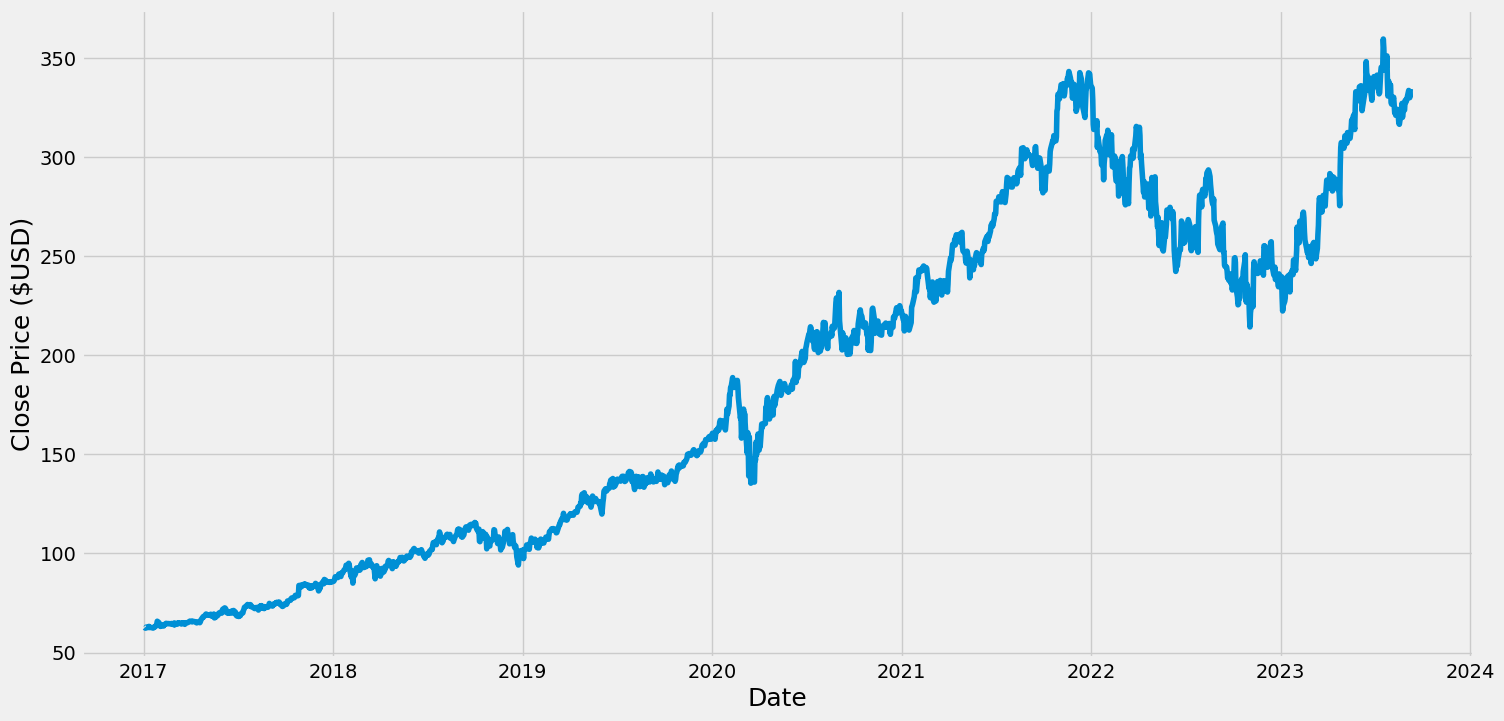

In [6]:
# Visualize closing prices of gathered historic data

plt.figure(figsize=(16,8))
plt.title='Close Price History'
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price ($USD)', fontsize=18)

plt.show()

<h1>Data Preprocessing</h1>

In [7]:
# Data preprocessing

# Filter to relevant features only
data = df.filter(['Close', 'Open', 'High', 'Low', 'Volume'])

# Isolate dates as independent variables. This may be redundant later but useful in attaching dates to final predictions.
date_train = df.index.strftime("%Y-%m-%d").tolist()
date_train = [pd.to_datetime(d) for d in date_train]

# Convert dataframe to a numpy array
dataset = data.values

# Compute row count to train the model on => 80% of data for training
training_data_len = math.ceil(len(dataset) * 0.8)
print(training_data_len)

1346


In [8]:
# Scale the data for preprocessing. Simply normalizes each column's values from 0:1
scaler = MinMaxScaler(feature_range=(0,1))

In [9]:
# Create the training data set
def data_prep(df, batch_size, forecast_size, scaler):
  df_slice = df[0:training_data_len]
  
  date_train = df_slice.index.strftime("%Y-%m-%d").tolist()
  date_train = [pd.to_datetime(d) for d in date_train]
  df_train = df_slice.filter(['Close', 'Open', 'High', 'Low', 'Volume'])
  df_train_scaled = scaler.fit_transform(np.float32(df_train))  
  
  df_train_scaled = df_train_scaled[0:training_data_len, :]

  x_train = []
  y_train = []
  
  # Columns in place --> 0: Close, 1: Open, 2: High, 3: Low, 4: Volume
  for i in range(batch_size, len(df_train_scaled)-forecast_size+1):
    x_train.append(df_train_scaled[i-batch_size:i, 0:df_train.shape[1]])        # All features at positions 0 to 59
    y_train.append(df_train_scaled[i+forecast_size-1:i+forecast_size,1])        # Open at position 60
  
  return np.array(x_train), np.array(y_train), df_train, date_train


   
Lstm_x, Lstm_y, df_train, date_train = data_prep(df, 60, 1, scaler)
      

<h1>Define the Models</h1>

In [10]:
# Build the LSTM Model(s)

def old_model(x, y):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(x.shape[1], x.shape[2])))
    model.add(LSTM(64, return_sequences=False)) 
    model.add(Dense(32))
    model.add(Dense(y.shape[1])) 
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x, y, epochs=4, batch_size=1)
    
    print('y.shape[1]: ', y.shape[1])
    print('x.shape[1]: ', x.shape[1])
    print('x.shape[2]: ', x.shape[2])
    
    return model


def lstm_fallback(x, y):
    model = Sequential()
    model.add(LSTM(64, activation='relu',input_shape=(x.shape[1], x.shape[2]),  return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y.shape[1], activation='relu'))
    opt = optimizers.legacy.Adam(lr=0.001, decay=1e-6)  
    model.compile(
            loss='mse',
            optimizer=opt,
        )
    es = callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(x, y, epochs=4, verbose=1, callbacks=[es], validation_split=0.1, batch_size=16)
    return model


def Lstm_model1(x, y):
    regressor = Sequential()

    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x.shape[1], x.shape[2])))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))
    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    es = callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    regressor.fit(x, y, epochs = 6, validation_split=0.1, batch_size = 64, verbose=1, callbacks=[es])
    return regressor
    

def Lstm_model2(x,y):
    model=Sequential()
    
    model.add(LSTM(20,return_sequences=True,input_shape=(x.shape[1], x.shape[2])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    #model.add(LSTM(15,return_sequences=True))
    #model.add(Dropout(0.2))
    #model.add(BatchNormalization())
    model.add(LSTM(15))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    
    adam = optimizers.legacy.Adam(0.001)
    model.compile(loss='mean_squared_error',optimizer=adam)
    
    es = callbacks.EarlyStopping(monitor='loss', patience=15, restore_best_weights=True)
    model.fit(x, y,validation_split=0.2,epochs=6,batch_size=64,verbose=1, callbacks=[es])
    return model

<h1>Predicting</h1>

In [11]:
# Prediction

def predict_open(model,date_train,Lstm_x,df_train, future, Scale):
    forecasting_dates=pd.date_range(list(date_train)[-1], periods=future, freq='1d').tolist()
    predicted=model.predict(Lstm_x[-future:])
    predicted1=np.repeat(predicted, df_train.shape[1], axis=-1)
    predicted_descaled=Scale.inverse_transform(predicted1)[:,0]
    return predicted_descaled,forecasting_dates

def output_prep(forecasting_dates,predicted_descaled):
    dates=[]
    for i in forecasting_dates:
        dates.append(i.date())
    df_final=pd.DataFrame(columns=['Date','Open'])
    df_final['Date']=pd.to_datetime(dates)
    df_final['Open']=predicted_descaled
    return df_final


In [12]:
def results(df, lookback, future, Scale, x):
    Lstm_x, Lstm_y, df_train, date_train = data_prep(df, lookback, future, Scale)
    model=Lstm_model1(Lstm_x,Lstm_y)
    loss=pd.DataFrame(model.history.history)
    loss.plot()
    future=30
    predicted_descaled,forecasting_dates=predict_open(model,date_train,Lstm_x,df_train,future, Scale)
    results=output_prep(forecasting_dates,predicted_descaled)   
    print(results.head())
    plt.show()
    fig = px.area(results, x="Date", y="Open", title=x)
    fig.update_yaxes(range=[results.Open.min()-10, results.Open.max()+10])
    fig.show()
    
    return results


In [13]:
def results1(df, lookback, future, Scale, x):
    Lstm_x, Lstm_y, df_train, date_train = data_prep(df, lookback, future, Scale)
    model=Lstm_model2(Lstm_x,Lstm_y)
    loss=pd.DataFrame(model.history.history)
    loss.plot()
    future=30
    predicted_descaled,forecasting_dates=predict_open(model,date_train,Lstm_x,df_train,future, Scale)
    results=output_prep(forecasting_dates,predicted_descaled)   
    print(results.head())
    plt.show()
    fig = px.area(results, x="Date", y="Open", title=x)
    fig.update_yaxes(range=[results.Open.min()-10, results.Open.max()+10])
    fig.show()
    
    return results
    
    

In [30]:
def old_model_results(df, iteration_size, forecast_size, scaler, x):
    Lstm_x, Lstm_y, df_train, date_train = data_prep(df, iteration_size, forecast_size, scaler)
    model=old_model(Lstm_x,Lstm_y)
    loss=pd.DataFrame(model.history.history)
    loss.plot()
    forecast_size=30
    predicted_descaled,forecasting_dates=predict_open(model,date_train,Lstm_x,df_train,forecast_size, scaler)
    results=output_prep(forecasting_dates,predicted_descaled)   
    print(results.head())
    plt.show()
    fig = px.area(results, x="Date", y="Open", title=x)
    fig.update_yaxes(range=[results.Open.min()-10, results.Open.max()+10])
    fig.show()
    
    return results

<h1>Results</h1>

Epoch 1/6
19/19 [==============================] - 3s 62ms/step - loss: 0.0549 - val_loss: 0.0302
Epoch 2/6
19/19 [==============================] - 1s 31ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 3/6
19/19 [==============================] - 1s 32ms/step - loss: 0.0040 - val_loss: 0.0107
Epoch 4/6
19/19 [==============================] - 1s 32ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 5/6
19/19 [==============================] - 1s 32ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 6/6
1/1 [==============================] - 1s 510ms/step
        Date        Open
0 2022-05-06  289.413605
1 2022-05-07  289.539520
2 2022-05-08  289.819092
3 2022-05-09  290.283447
4 2022-05-10  290.850098


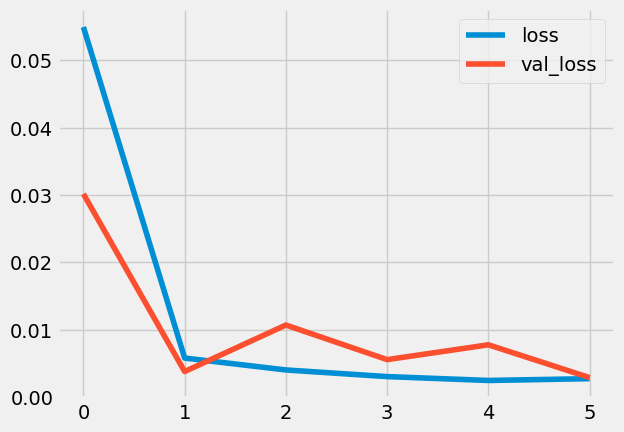

In [15]:
results = results(df, 30, 1, scaler, 'MSFT')

Epoch 1/6
17/17 [==============================] - 2s 29ms/step - loss: 0.2158 - val_loss: 0.4606
Epoch 2/6
17/17 [==============================] - 0s 10ms/step - loss: 0.1255 - val_loss: 0.4412
Epoch 3/6
17/17 [==============================] - 0s 10ms/step - loss: 0.0864 - val_loss: 0.4142
Epoch 4/6
17/17 [==============================] - 0s 10ms/step - loss: 0.0663 - val_loss: 0.3768
Epoch 5/6
17/17 [==============================] - 0s 10ms/step - loss: 0.0553 - val_loss: 0.3495
Epoch 6/6
1/1 [==============================] - 0s 284ms/step
        Date        Open
0 2022-05-06  134.132187
1 2022-05-07  134.253510
2 2022-05-08  134.353546
3 2022-05-09  134.525543
4 2022-05-10  134.695847


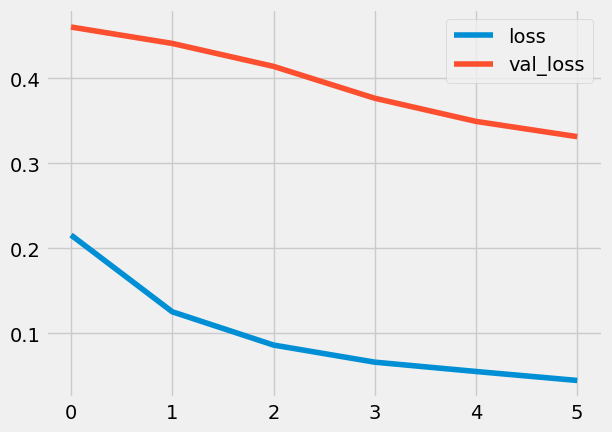

In [16]:
results1 = results1(df, 30, 1, scaler, 'MSFT')

Epoch 1/4
1316/1316 [==============================] - 9s 6ms/step - loss: 0.0015
Epoch 2/4
1316/1316 [==============================] - 8s 6ms/step - loss: 7.9911e-04
Epoch 3/4
1316/1316 [==============================] - 7s 5ms/step - loss: 7.3117e-04
Epoch 4/4
1316/1316 [==============================] - 7s 6ms/step - loss: 4.9394e-04
y.shape[1]:  1
x.shape[1]:  30
x.shape[2]:  5
1/1 [==============================] - 0s 296ms/step
        Date        Open
0 2022-05-06  300.611481
1 2022-05-07  301.540894
2 2022-05-08  304.010406
3 2022-05-09  308.385132
4 2022-05-10  310.882355


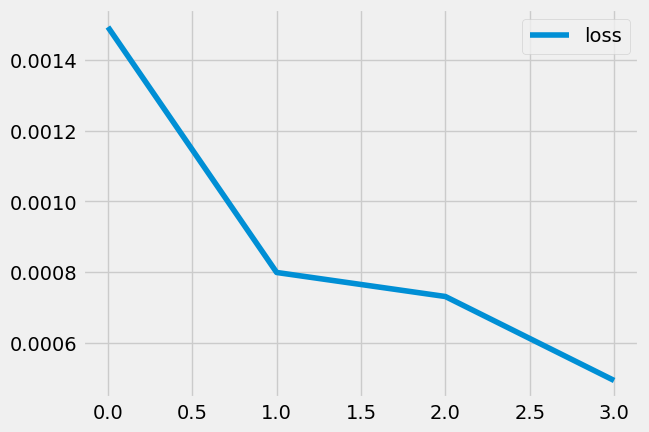

In [31]:
old_model_outputs = old_model_results(df, 30, 1, scaler, 'MSFT')

In [18]:
# # Create the testing data set

# # Array containing scaled values from index 1543 to 2003
# test_data = scaled_data[training_data_len - 60: , :]

# # Create the data sets x_test and y_test
# x_test = []
# y_test = dataset[training_data_len:, :]

# for i in range(60, len(test_data)):
#   x_test.append(test_data[i-60:i, 0])


In [19]:
# # Convert the data to a numpy array

# x_test = np.array(x_test)


In [20]:
# # Reshape the data

# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  # Num of rows, num of columns, num of features (just the close price)


In [21]:
# # Retrieve model's predicted price values

# predictions = model.predict(x_test)
# predictions.shape

In [22]:
# predictions = scaler.inverse_transform(predictions)   # Unscale predictions to compare to original closing prices (y_test)

In [23]:
# # Evaluate root mean square error (RMSE) => Standard deviation of the residuals

# rmse = np.sqrt( np.mean( predictions - y_test )**2 )
# print(rmse)

In [24]:
# # Plot the data

# train = data[:training_data_len].copy()
# valid = data[training_data_len:].copy()

# valid['Predictions'] = predictions[:,0]

# # Visualize the data
# plt.figure(figsize=(16,8))
# plt.title='First Predicted Day'
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Close Price USD ($)', fontsize=18)
# plt.plot(train['Close'][training_data_len-10:])
# plt.plot(valid[['Close', 'Predictions']])

# plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
# plt.show()

In [25]:
# # Display valid and predicted prices
# predictions

# valid

In [26]:
# # Predict closing price for ^GSPC stock on december 18, 2019

# #.Retrieve actual quote
# apple_quote=web.get_data_yahoo('MSFT', start='2012-01-01', end='2023-09-05')

# # Create a new dataframe
# new_df = apple_quote.filter(['Close'])

# # Retrieve only last 60 days of data and convert to array
# last_sixty_days = new_df[-60:].values

# # Scale the data to [0:1]
# last_sixty_days_scaled = scaler.transform(last_sixty_days)

# # Initialize list
# new_x_test = []
# new_x_test.append(last_sixty_days_scaled)

# # Convert to numpy array
# new_x_test = np.array(new_x_test)

# # Reshape
# new_x_test = np.reshape(new_x_test, (new_x_test.shape[0], new_x_test.shape[1], 1))
# # print(new_x_test)
# # Calculate predictions
# pred_price = model.predict(new_x_test)

# # Rescale predictions
# pred_price = scaler.inverse_transform(pred_price)

# flattener = lambda x: x.flatten()
# pred_price = flattener(pred_price)

# print(pred_price)

In [27]:
# # Evaluate efficacy of model

# # Retrieve actual future quote data
# actual_apple_quote=web.get_data_yahoo('MSFT', start='2023-09-06', end='2023-09-20')
# actual_apple_quote = actual_apple_quote['Close']
# print(actual_apple_quote)

In [28]:
## Below code added as of 1/1/2023

In [29]:
# # Calculate confusion matrix from actual and predicted values

# y_actual = y_test
# y_hat = predictions

# overshot = 0
# undershot = 0


# for i in range(0, len(y_actual)):
#   if y_actual[i] > y_hat[i]:
#     undershot+=1
#   else:
#     overshot+=1


# print(np.average(y_actual-y_hat))
# print(overshot, undershot)

